In [77]:
import torch    
import json 
from ptlpinns.models import model, transfer
from ptlpinns.perturbation import LPM, standard
from ptlpinns.odes import forcing, numerical, equations
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid

### Load model

In [78]:
name = "underdamped_k12"

overdamped_path = f"/home/dda24/PTL-PINNs/ptlpinns/models/train/{name}"
overdamped_name = f"model_{name}.pth"
overdamped_model, training_log = model.load_model(overdamped_path, overdamped_name)

12 True True True 1.0 16 [128, 128, 256]


### Problem definition

In [79]:
N = 500
t_span = (0, 10)
t_eval = np.linspace(t_span[0], t_span[1], N)

### Compute latent representations

In [80]:
H_dict = transfer.compute_H_dict(overdamped_model, N=N, bias=True, t_span=t_span)

### Transfer parameters

In [81]:
w_list_transfer = [1, 1, 1]
zeta_list = [0.4, 0.6, 0.6]

def forcing(numpy=False):
    if not numpy:
        def force(t):
            return torch.stack((torch.zeros_like(t), torch.zeros_like(t)), dim=1)
    else:
        def force(t):
            return np.stack((np.zeros_like(t), np.zeros_like(t)), axis=1)
    return force

forcing_list = [forcing(True), forcing(True), forcing(True), forcing(True), forcing(True)]

forcing_1D = lambda t: np.zeros_like(t)
ic_list = [[1, 0], [1, 0], [1, 0]]
epsilon_list = [0.5, 0.5, 0.5]
p_list = [6]
q = [(3, 1)]

### Numerical solver

In [82]:
numerical_list = []

for zeta in zeta_list:
    ode = equations.ode_oscillator_1D(w_0=w_list_transfer[0], zeta=zeta, forcing_1D=forcing_1D, q=q, epsilon=epsilon_list[0])
    numerical_list.append(numerical.solve_ode_equation(ode, (t_eval[0], t_eval[-1]), t_eval, ic_list[0]))

### PINN

In [83]:
NN_TL_solution, perturbation_solution, _ = transfer.compute_perturbation_solution(w_list_transfer, zeta_list, epsilon_list, p_list, ic_list, forcing_list, H_dict, t_eval, training_log, all_p=True, comp_time=False, solver="standard", power=q)
NN_TL_solution = NN_TL_solution.squeeze()

In [84]:
NN_TL_solution.shape

(500, 3, 2)

In [85]:
PINN_solution = []

for perturbation_zeta in perturbation_solution:

    perturbation = []
    for perturbation_order in perturbation_zeta:

        perturbation.append(perturbation_order[:, 0])

    PINN_solution.append(standard.calculate_general_series(perturbation, epsilon_list[0]))

zeta: 0.4, order: 0, mean error absolute: 0.050634789218822536
zeta: 0.4, order: 1, mean error absolute: 0.016264213556359777
zeta: 0.4, order: 2, mean error absolute: 0.0043974920254959355
zeta: 0.4, order: 3, mean error absolute: 0.007337786202585614
zeta: 0.4, order: 4, mean error absolute: 0.005748915949053249
zeta: 0.4, order: 5, mean error absolute: 0.006371164225829032


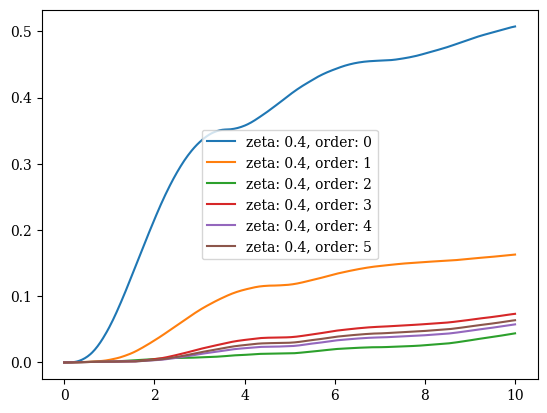

zeta: 0.6, order: 0, mean error absolute: 0.03625780684716439
zeta: 0.6, order: 1, mean error absolute: 0.01842408689432563
zeta: 0.6, order: 2, mean error absolute: 0.007527349652912331
zeta: 0.6, order: 3, mean error absolute: 0.011052652012550714
zeta: 0.6, order: 4, mean error absolute: 0.009717277123142421
zeta: 0.6, order: 5, mean error absolute: 0.010215851861754036


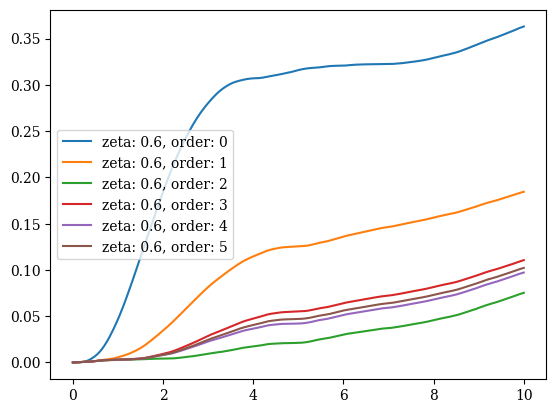

zeta: 0.6, order: 0, mean error absolute: 0.03625780684716439
zeta: 0.6, order: 1, mean error absolute: 0.01842408689432563
zeta: 0.6, order: 2, mean error absolute: 0.007527349652912331
zeta: 0.6, order: 3, mean error absolute: 0.011052652012550714
zeta: 0.6, order: 4, mean error absolute: 0.009717277123142421
zeta: 0.6, order: 5, mean error absolute: 0.010215851861754036


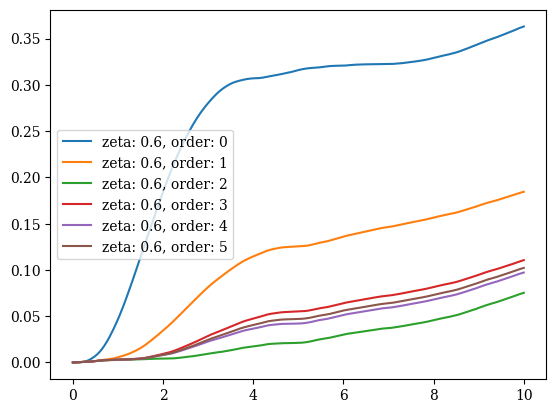

In [86]:
standard.plot_error_by_order(t_eval, PINN_solution, numerical_list, p_list, zeta_list, "zeta")

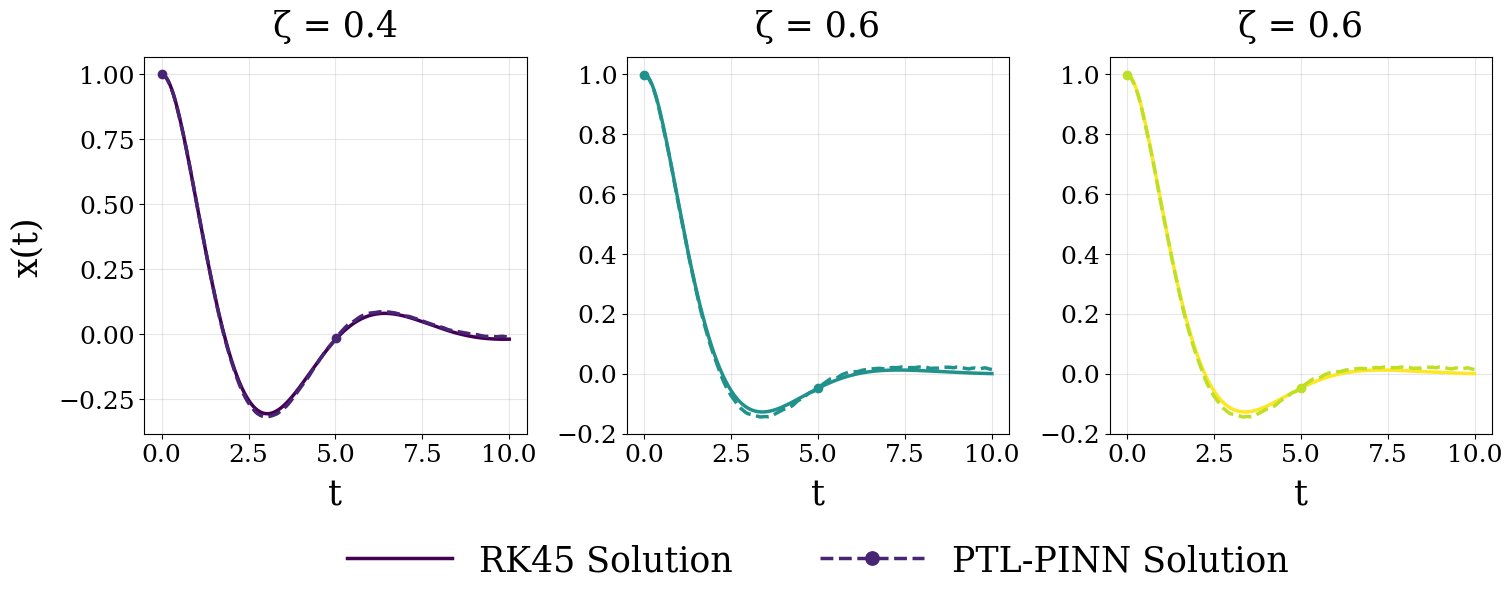

In [87]:
standard.plot_compare_multiple_zeta(t_eval, zeta_list, numerical_list, NN_TL_solution)


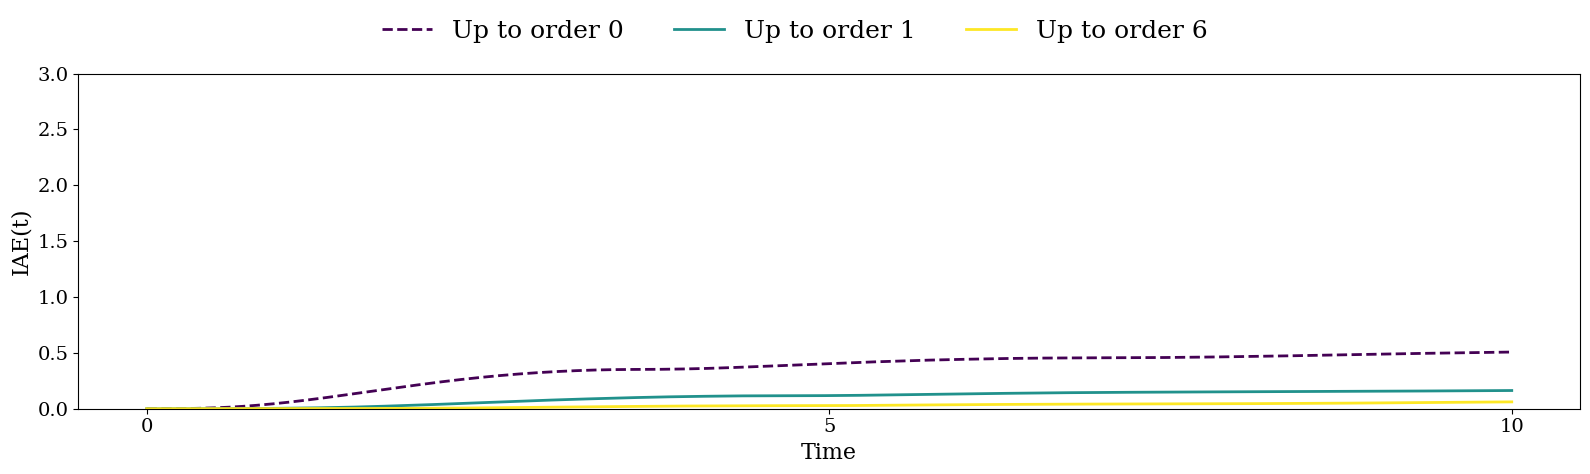

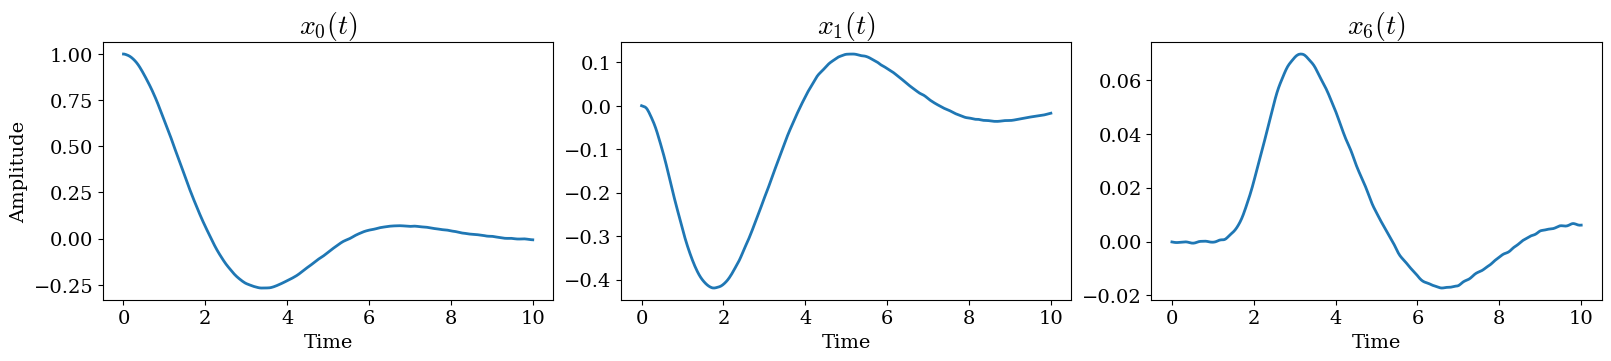

In [88]:
perturbation_solution_show = perturbation_solution[0]

PINN_x_solution = [perturbation_solution_show[i][:, 0] for i in range(len(perturbation_solution_show))]
PINN_x_solution = standard.calculate_general_series(PINN_x_solution, epsilon=epsilon_list[0])

standard.plot_IAE_and_subplots(PINN_x_solution, numerical_list[0], perturbation_solution_show, t_eval, selected_orders=[0, 1, 6], ylim=(0, 3))

/tmp/ipykernel_132965/3129563047.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis", 3)


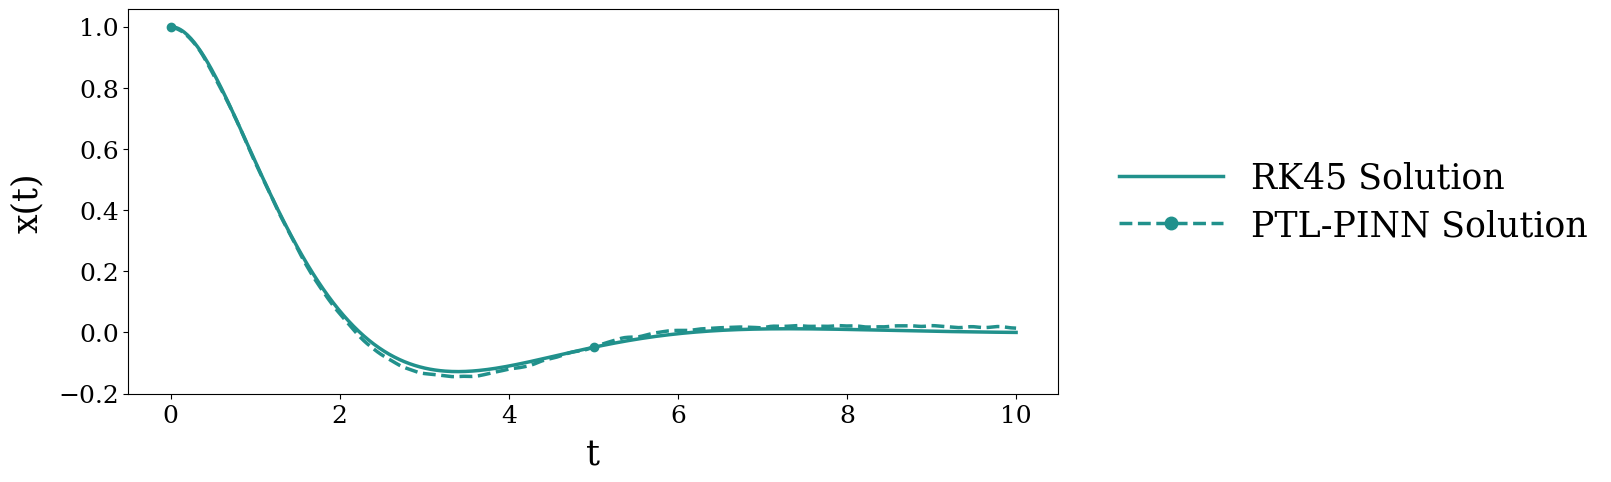

In [89]:
import matplotlib.cm as cm

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["DejaVu Serif"],
    "mathtext.fontset": "cm",
    "text.usetex": False,
})

def plot_solution(t_eval, y_num, y_nn, i = 0):
    title_fs  = 25
    label_fs  = 25
    tick_fs   = 18
    legend_fs = 25
    cmap = cm.get_cmap("viridis", 3)

    fig, ax = plt.subplots(figsize=(12, 5))

    base_color = cmap(i / 2)
    rk_color   = base_color
    pinn_color = cm.viridis(0.1 + 0.8 * i / 2)

    ax.plot(t_eval, y_num,
            label="RK45 Solution",
            color=rk_color, linewidth=2.5)

    ax.plot(t_eval, y_nn,
            label="PTL-PINN Solution",
            color=pinn_color, linewidth=2.5,
            linestyle="--", marker="o", markevery=250)

    ax.set_xlabel("t", fontsize=label_fs, labelpad=8)
    ax.set_ylabel("x(t)", fontsize=label_fs, labelpad=10)

    ax.tick_params(axis='both', labelsize=tick_fs)

    # Set y-limits with padding
    y_min = min(np.min(y_num), np.min(y_nn))
    y_max = max(np.max(y_num), np.max(y_nn))
    pad = 0.05 * max(1e-12, (y_max - y_min))
    ax.set_ylim(y_min - pad, y_max + pad)

    ax.legend(
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),  # (x, y): anchor the legend outside the right border
    fontsize=legend_fs,
    frameon=False,
    handlelength=3.0,
    markerscale=1.5,
    labelspacing=0.4,
    borderaxespad=0.8)
    plt.show()

plot_solution(t_eval, numerical_list[1][0, :], NN_TL_solution[:, 1, 0], i = 1)

In [90]:
scale = int(10000 / N)
scale

20

In [91]:
ode_high_acc = equations.ode_oscillator_1D(w_0=1, zeta=zeta_list[1], forcing_1D=forcing_1D, q=q, epsilon=epsilon_list[0])
dt = (t_eval[1] - t_eval[0])/scale
t_eval_high_acc = np.linspace(t_span[0], t_span[1], (t_eval.size - 1)*scale + 1)
num_high_acc = numerical.solve_ode_equation(ode_high_acc, (t_eval_high_acc[0], t_eval_high_acc[-1]), t_eval_high_acc, ic_list[0])[0, :]

In [92]:
t_eval_high_acc[1] - t_eval_high_acc[0]

np.float64(0.001002004008016032)

In [93]:
error = []
for i in range(p_list[0]):
    error.append(np.mean(np.abs(PINN_solution[1][i] - num_high_acc[::scale])))

In [94]:
num_low_acc = numerical.solve_ode_equation(ode_high_acc, (t_eval[0], t_eval[-1]), t_eval, ic_list[0], rtol=1e-3, atol=1e-3, method="RK45")[0, :]
np.mean(np.abs(num_low_acc - num_high_acc[::scale]))

np.float64(0.0009281388497902039)

In [95]:
error

[np.float64(0.03625780684716438),
 np.float64(0.018424086894325637),
 np.float64(0.007527349652912333),
 np.float64(0.01105265201255072),
 np.float64(0.009717277123142427),
 np.float64(0.01021585186175404)]

### zeta = 0.6

```
N = 50

[np.float64(0.043237598037330224),
 np.float64(0.00865638407932819),
 np.float64(0.01004633285565079),
 np.float64(0.007482921332746192),
 np.float64(0.008353694680760394),
 np.float64(0.008064142525286665)]

N = 100:

[np.float64(0.035658771008880416),
 np.float64(0.01867532942168455),
 np.float64(0.007979780820241842),
 np.float64(0.011457863547567204),
 np.float64(0.010185542305771464),
 np.float64(0.01065488928815103)]

N = 200:

[np.float64(0.036036973378318286),
 np.float64(0.018571001879247998),
 np.float64(0.00773537424367451),
 np.float64(0.011256323299227775),
 np.float64(0.00994291196398367),
 np.float64(0.01043166390959783)]

N = 400:

[np.float64(0.03622197598904485),
 np.float64(0.01845070946845249),
 np.float64(0.007564566140341254),
 np.float64(0.011089107382480128),
 np.float64(0.009757817384592025),
 np.float64(0.010254248746668368)]

N = 500:

[np.float64(0.03625780684716438),
 np.float64(0.018424086894325637),
 np.float64(0.007527349652912333),
 np.float64(0.01105265201255072),
 np.float64(0.009717277123142427),
 np.float64(0.01021585186175404)]

```